In [1]:
import math
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def calc_distance(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    # Change in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    # Distance in kilometers
    distance = R * c
    return distance

In [3]:
def calculate_end_time(index, row, df):
    truckLat = row['current_latitude']
    truckLong = row['current_longitude']
    distance = calc_distance(switzLat, switzLong, truckLat, truckLong)
    time_hours = distance/60 #60 kmh avg speed
    start_time = datetime(2024,5, row['date_day'], row['time_hours'], row['time_mins'], 0)
    delta = timedelta(hours=time_hours)
    end_time = start_time + delta
    df.loc[index] = [start_time.day, start_time.hour, start_time.minute, end_time.day, end_time.hour, end_time.minute ]

In [4]:
switzLat = 46.800663464 
switzLong = 8.222665776

%load_ext sql
%sql trino://streambased-server:8080/kafka

Deploy Flask apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


Connecting to 'trino://streambased-server:8080/kafka'

In [5]:
result = %sql SELECT * FROM kafka.streambased.truck WHERE truck_id = 'truck-1' ORDER BY _timestamp desc LIMIT 100
import pandas as pd
inDf = result.DataFrame()

Running query in 'trino://streambased-server:8080/kafka'

In [6]:
df = pd.DataFrame(columns=['start_day','start_hour', 'start_mins', 'predicted_end_day', 'predicted_end_hour', 'predicted_end_mins'])
for index, row in inDf.iterrows():
    calculate_end_time(index,row,df)

In [7]:
df

,start_day,start_hour,start_mins,predicted_end_day,predicted_end_hour,predicted_end_mins
0,13,9,49,13,12,13
1,15,14,31,15,17,8
2,16,10,35,16,11,51
3,11,3,18,11,4,42
4,16,21,16,16,23,31
...,...,...,...,...,...,...
95,12,11,40,12,13,2
96,12,20,11,12,22,1
97,17,6,42,17,8,26
98,16,22,14,17,0,53


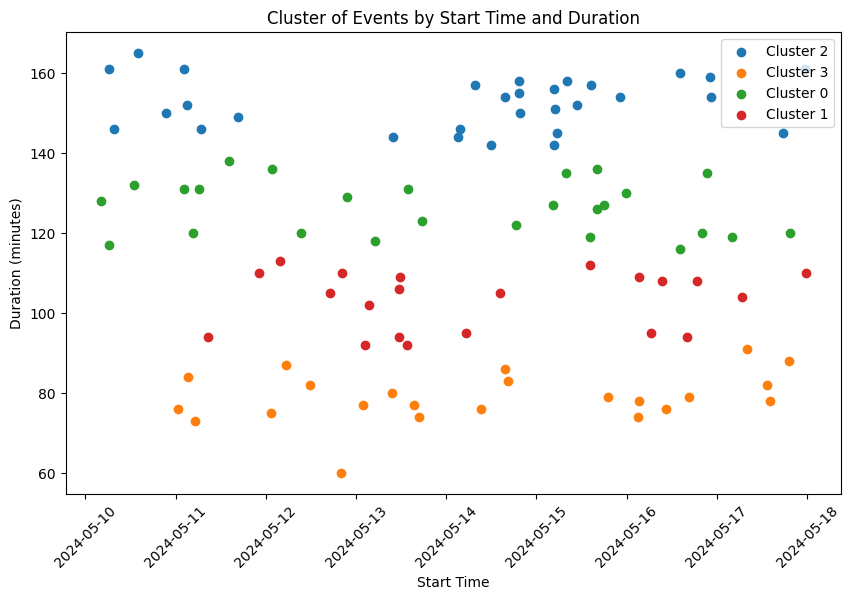

In [8]:


# Convert start and end times to datetime objects
df['start_time'] = pd.to_datetime("2024 5 " + df['start_day'].astype(str) + ' ' +
                                  df['start_hour'].astype(str) + ':' +
                                  df['start_mins'].astype(str), format='%Y %m %d %H:%M')
df['end_time'] = pd.to_datetime("2024 5 " + df['predicted_end_day'].astype(str) + ' ' +
                                df['predicted_end_hour'].astype(str) + ':' +
                                df['predicted_end_mins'].astype(str), format='%Y %m %d %H:%M')
# Feature Engineering
df['duration'] = (df['end_time'] - df['start_time']).dt.total_seconds() / 60  # Duration in minutes
# More features can be added here such as day of the week, etc.
# Clustering
kmeans = KMeans(n_clusters=4, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['duration']])  # Use more features if necessary
# Visualization
plt.figure(figsize=(10, 6))
for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster]
    plt.scatter(cluster_data['start_time'], cluster_data['duration'], label=f'Cluster {cluster}')
plt.legend()
plt.title('Cluster of Events by Start Time and Duration')
plt.xlabel('Start Time')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()